In [1]:
library(Seurat)
library(dplyr)
library(dplyr)
library(ggplot2)


earlyFile <- "./load_files/Early_seu.rds"

if (!file.exists(earlyFile)){
    ## Subset to early ExNs
    seu <- readRDS(file = paste0("./load_files/ExN.spread_region.harmony.v1.harmony.rds"))

    ## Only 8 cells annotated as "IPC EOMES VIM", update it to "IPC EOMES NEUROG1"
    set.seed(42)
    early <- subset(seu, cbnage %in% c('E37', 'E42-43')) %>%
                RunUMAP(., dims = 1:30, reduction = "harmony", umap.method = "umap-learn", metric = "correlation")
    early@meta.data$subtype <- gsub("IPC EOMES VIM", "IPC EOMES NEUROG1", early@meta.data$subtype)
    saveRDS(early, file = earlyFile)
}
early <- readRDS(earlyFile)


Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




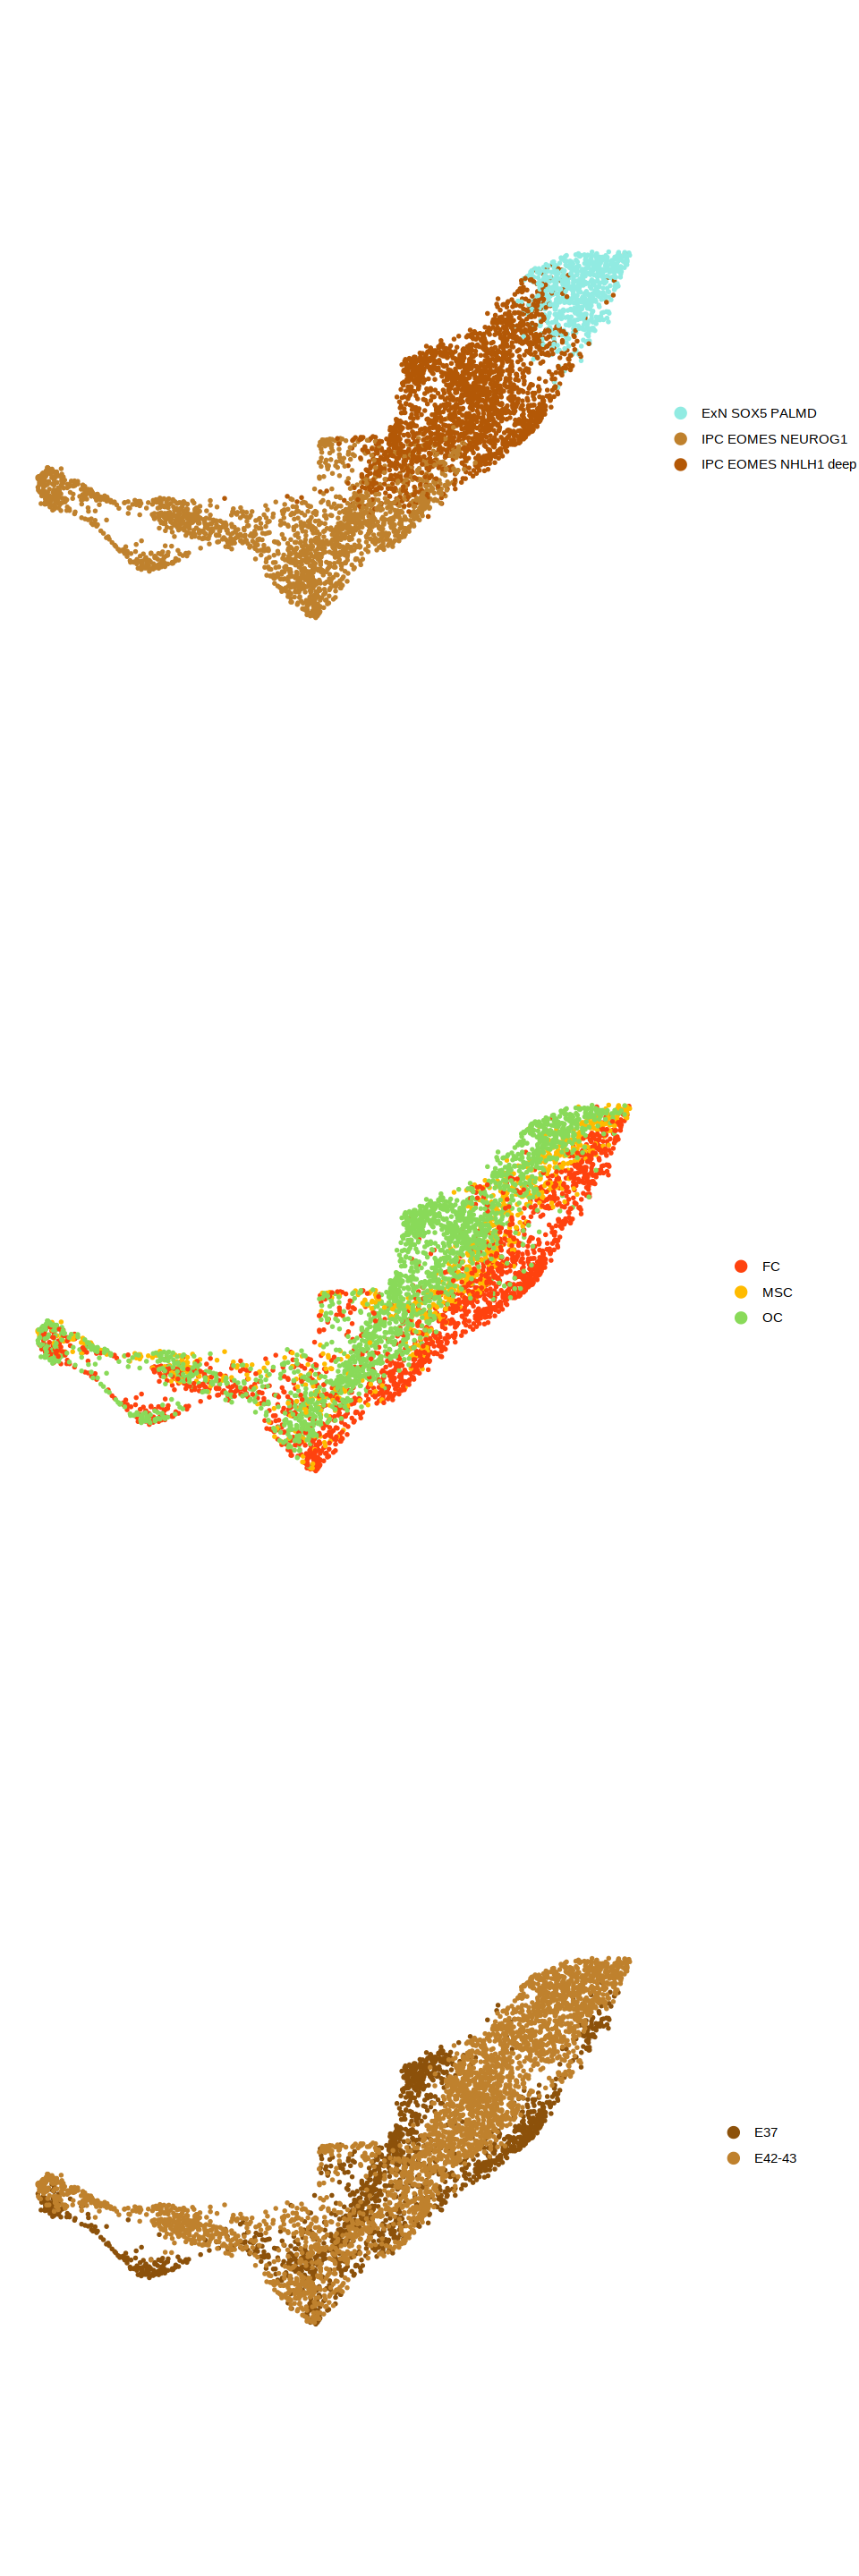

In [2]:
##------------------------------------------------------------------------
## Plot UMAP
cls_cols <- setNames(c("#bf812d", "#b35806", "#91ebe2"),
                    c("IPC EOMES NEUROG1", "IPC EOMES NHLH1 deep", "ExN SOX5 PALMD"))
reg_cols <- c("#FF420E", "#FFBB00", "#4CB5F5", "#89DA59", "#878787", "#B037C4") %>% 
                setNames(., c("FC", "MSC", "TC", "OC", "Insula", "GE"))
age_cols <- c("#8c510a", "#bf812d", "#dfc27d", "#c7eae5", "#80cdc1", "#35978f", "#01665e") %>% 
                setNames(., c("E37", "E42-43", "E54", "E62-64", "E77-78", "E93", "E110"))

plist <- lapply(c("subtype", "lobe", "cbnage"), function(group.by){
    cols <- switch(group.by,
                subtype = cls_cols,
                lobe = reg_cols, 
                cbnage = age_cols)
    p <- DimPlot(early, group.by = group.by, 
                pt.size = 0.5, cols = cols) +
            theme_void()+
            coord_fixed() + 
            theme(legend.position = "right")
    return(p)
    })
pcbn <- patchwork::wrap_plots(plist, nrow = 3, ncol = 1)
options(repr.plot.width=8, repr.plot.height=24)
pcbn

In [3]:
jpeg(paste0("./report/", "Early_UMAP_spread_Harmony_identities.jpeg"), 
     width = 5, height = 15, unit = "in", res = 300)
print(pcbn)
dev.off()

png 
  2

In [4]:
##------------------------------------------------------------------------
## Find Shared & divergent subtype markers between early and late wave of deep layer neurogenesis
## Compare early (E37-43) and late (E54-64) deep layer neurogenesis
deepFile <- "./load_files/Early_deep_seu.rds"
if (!file.exists(deepFile)){
    seu <- readRDS(file = paste0("./load_files/ExN.spread_region.harmony.v1.harmony.rds"))
    deep <- subset(seu, subtype %in% c("IPC EOMES NEUROG1", "IPC EOMES NHLH1 deep", "ExN SOX5 PALMD") & 
               cbnage %in% c("E37", "E42-43", "E54", "E62-64"))
    deep@meta.data$stage <- ifelse(deep@meta.data$cbnage %in% c("E37", "E42-43"), "early", "late")
    deep@meta.data$subtype_stage <- paste0(deep@meta.data$subtype, "|", deep@meta.data$stage)
    saveRDS(deep, file = deepFile)
}
deep <- readRDS(deepFile)


## Calculate markers
MarFile <- paste0("./load_files/", "Early_deep_signature_res.Rdata")
if (!file.exists(MarFile)){
    regs <- c('FC', 'MSC', "OC")

    ## Compare across subtypes
    all_mar <- lapply(regs, function(reg) {
        reg_deep <- subset(deep, lobe %in% reg)

        ## Subtype markers
        mar_res <- lapply(c("early", "late"), function(stg) {
            sub_stg <- reg_deep[, reg_deep@meta.data$stage %in% stg]
            Idents(sub_stg) <- "subtype_stage"
            mars <- FindAllMarkers(sub_stg, min.pct = 0.1, logfc.threshold = 0.1, 
                                   only.pos = TRUE, max.cells.per.ident = 500) %>%
                        mutate(ratio_fc = (pct.1 + 0.01)/(pct.2 + 0.01)) %>%
                        mutate(subtype = extract_field(as.character(cluster), 1, "|")) %>%
                        mutate(region = reg, stage = stg)
            return(mars)
            }) %>%
            do.call(rbind, .)
        return(mar_res)
        }) %>%
            do.call(rbind, .)

    ## Compare the same cell subtype between early and late stages
    all_enr <- lapply(regs, function(reg) {
        reg_deep <- subset(deep, lobe %in% reg)
        ## Early - Late DEGs
        sel_cls <- c("IPC EOMES NEUROG1", "IPC EOMES NHLH1 deep", "ExN SOX5 PALMD")
        enr_res <- lapply(sel_cls, function(cls){
            sub_sub <- reg_deep[, reg_deep@meta.data$subtype %in% cls]
            Idents(sub_sub) <- "subtype_stage"
            enr <- FindAllMarkers(sub_sub, min.pct = 0.1, logfc.threshold = 0.1, 
                                  only.pos = TRUE, max.cells.per.ident = 500) %>%
                        mutate(ratio_fc = (pct.1 + 0.01)/(pct.2 + 0.01)) %>%
                        mutate(subtype = cls, region = reg, stage = extract_field(as.character(cluster), 2, "|"))
            return(enr)
            }) %>%
            do.call(rbind, .)
        return(enr_res)
        }) %>%
            do.call(rbind, .)
save(all_mar, all_enr, file = MarFile)
}

load(MarFile)

In [5]:
## Find top 5 shared markers
sel_cls <- c("IPC EOMES NEUROG1", "IPC EOMES NHLH1 deep", "ExN SOX5 PALMD")
sh_mars <- all_mar %>%
        mutate(type_reg = paste0(subtype, "|", region)) %>%
        filter(pct.1 >= 0.2 & ratio_fc >= 1.2 & p_val_adj <= 0.001) %>%
        group_by(type_reg, gene) %>%
        summarize(nhits = n(), minrfc = min(ratio_fc), 
                  minafc = min(avg_logFC), 
                  subtype = unique(subtype), 
                  pct.1 = min(pct.1), p_val_adj = max(p_val_adj)) %>%
        ungroup %>%
        filter(nhits == 2) %>%
        group_by(subtype, gene) %>%
        summarize(nregs = n(), minrfc = min(minrfc), minafc = min(minafc)) %>%
        filter(nregs == 3) %>%
        ungroup() %>%
        group_by(subtype) %>%
        top_n(., 5, wt = minrfc) %>%
        ungroup() %>%
        mutate(subtype = factor(subtype, levels = sel_cls)) %>%
        arrange(subtype, minrfc)

## Find top 5 early-/late- enriched markers by cell subtypes
early_mars <- all_enr %>%
        filter(stage %in% "early") %>%
        mutate(type_reg = paste0(subtype, "|", region)) %>%
        filter(pct.1 >= 0.2 & ratio_fc >= 1.2 & p_val_adj <= 0.001) %>%
        group_by(subtype, gene) %>%
        summarize(nhits = n(), minrfc = min(ratio_fc), 
                  minafc = min(avg_logFC), 
                  subtype = unique(subtype), 
                  pct.1 = min(pct.1), p_val_adj = max(p_val_adj)) %>%
        ungroup() %>%
        filter(nhits == 3) %>%
        filter(!gene %in% c("RPS4Y1", "RPS4Y2")) %>%
        filter(!grepl("^LOC", gene)) %>%
        group_by(subtype) %>%
        top_n(., 5, wt = minrfc) %>%
        ungroup() %>%
        mutate(subtype = factor(subtype, levels = sel_cls)) %>%
        arrange(subtype, minrfc)
late_mars <- all_enr %>%
        filter(stage %in% "late") %>%
        mutate(type_reg = paste0(subtype, "|", region)) %>%
        filter(pct.1 >= 0.2 & ratio_fc >= 1.2 & p_val_adj <= 0.001) %>%
        group_by(subtype, gene) %>%
        summarize(nhits = n(), minrfc = min(ratio_fc), 
                  minafc = min(avg_logFC), 
                  subtype = unique(subtype), 
                  pct.1 = min(pct.1), p_val_adj = max(p_val_adj)) %>%
        ungroup() %>%
        filter(nhits == 3) %>%
        filter(!gene %in% c("RPS4Y1", "RPS4Y2")) %>%
        filter(!grepl("^LOC", gene)) %>%
        group_by(subtype) %>%
        top_n(., 5, wt = minrfc) %>%
        ungroup() %>%
        mutate(subtype = factor(subtype, levels = sel_cls)) %>%
        arrange(subtype, minrfc)
sh_mars
early_mars
late_mars


`summarise()` has grouped output by 'type_reg'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'subtype'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'subtype'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'subtype'. You can override using the `.groups` argument.



subtype,gene,nregs,minrfc,minafc
<fct>,<chr>,<int>,<dbl>,<dbl>
IPC EOMES NEUROG1,ZWINT,3,6.452830,1.0210313
IPC EOMES NEUROG1,MKI67,3,7.548387,0.7758023
IPC EOMES NEUROG1,NUF2,3,7.964286,0.6942888
IPC EOMES NEUROG1,RRM2,3,8.000000,0.7030930
IPC EOMES NEUROG1,BIRC5,3,8.875000,0.8240864
IPC EOMES NHLH1 deep,ARL4D,3,1.641553,0.5128492
IPC EOMES NHLH1 deep,PPP1R17,3,1.696154,0.9457329
ExN SOX5 PALMD,MYT1L,3,2.486301,0.5743562
ExN SOX5 PALMD,MAPT,3,2.513514,0.7590375


subtype,gene,nhits,minrfc,minafc,pct.1,p_val_adj
<fct>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
IPC EOMES NEUROG1,CADPS,3,3.705128,0.5548151,0.279,4.542308e-13
IPC EOMES NEUROG1,DLL1,3,3.708333,0.9966319,0.475,1.601107e-29
IPC EOMES NEUROG1,HMGA2,3,5.402062,1.0719303,0.514,1.714156e-42
IPC EOMES NEUROG1,LHX9,3,7.000000,0.8136694,0.277,5.635370e-22
IPC EOMES NEUROG1,RGS16,3,7.511628,0.9406419,0.313,3.851184e-24
IPC EOMES NHLH1 deep,PCDH9,3,3.850000,0.6983186,0.331,3.962167e-19
IPC EOMES NHLH1 deep,FSTL5,3,4.016949,0.5007544,0.227,2.863029e-13
IPC EOMES NHLH1 deep,RGMB,3,4.716667,0.5811467,0.229,2.182418e-10
IPC EOMES NHLH1 deep,LHX9,3,5.198020,1.1347441,0.384,3.200157e-38


subtype,gene,nhits,minrfc,minafc,pct.1,p_val_adj
<fct>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
IPC EOMES NEUROG1,STMN2,3,2.290970,0.8630800,0.394,6.107284e-25
IPC EOMES NEUROG1,RPL31,3,2.380117,0.9130665,0.397,2.763140e-16
IPC EOMES NEUROG1,TRIM2,3,2.561798,0.6372945,0.265,2.824433e-10
IPC EOMES NEUROG1,NFIC,3,3.405063,0.5389194,0.237,6.701068e-10
IPC EOMES NEUROG1,NFIX,3,4.190476,0.9847549,0.488,9.028531e-35
IPC EOMES NHLH1 deep,MEIS2,3,2.386525,1.1090106,0.509,2.580396e-34
IPC EOMES NHLH1 deep,EPHB6,3,2.386555,0.7035841,0.201,6.829813e-10
IPC EOMES NHLH1 deep,MLLT3,3,3.132075,0.8514981,0.322,4.122190e-21
IPC EOMES NHLH1 deep,RPL31,3,3.317460,1.1887879,0.408,1.063260e-28


In [6]:
## Prepare data for the plot
deep_vis <- subset(deep, lobe %in% c("FC", "MSC", "OC"))
cls_ord <- lapply(c("FC", "MSC", "OC"), function(reg){
        aa <- rep(sel_cls, 2) %>% paste0(., "|", rep(c("early", "late"), each = length(sel_cls))) %>%
        paste0(., "|", reg)
        return(aa)
        }) %>%
        unlist()
deep_vis@meta.data$type_stage_reg <- paste0(deep_vis@meta.data$subtype, "|", 
                                            deep_vis@meta.data$stage, "|", 
                                            deep_vis@meta.data$lobe) %>%
                                    factor(., levels = cls_ord)

Warning message:
“Removed 221 rows containing missing values (geom_point).”


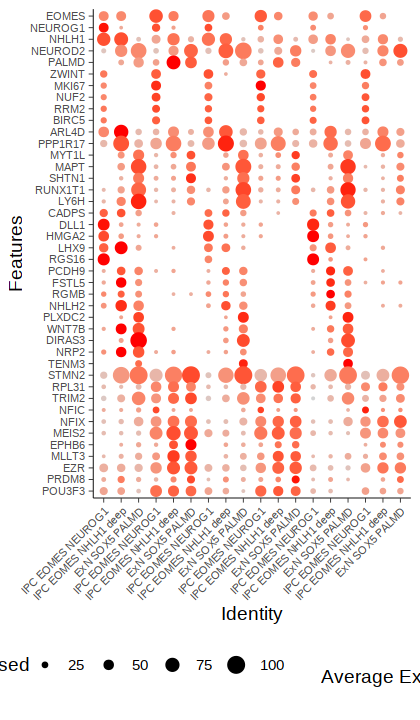

In [7]:
## Plot dotplots for the gene expression
Idents(deep_vis) <- "type_stage_reg"
genes <- c(c("EOMES", "NEUROG1", "NHLH1", "NEUROD2", "PALMD"), 
           sh_mars$gene, early_mars$gene, late_mars$gene) %>% unique
y_labels <- strsplit(cls_ord, "|", fixed = TRUE) %>%
            sapply(., "[", 1) %>%
            setNames(., cls_ord)
p <- DotPlot(object = deep_vis, features = genes, cols = c("lightgrey", "red"), dot.scale = 4, dot.min = 0.05) + 
        RotatedAxis() + 
        coord_flip() +
        theme_classic() +
        RotatedAxis() + 
        scale_y_discrete(breaks = cls_ord, 
                         labels = y_labels)+
        theme(axis.text.y = element_text(size = 6), axis.text.x = element_text(size = 6), 
                axis.line = element_line(size = 0.2), axis.ticks = element_line(size = 0.2),
                legend.position = "bottom")
options(repr.plot.width=3.5, repr.plot.height=6)

p

In [8]:
pdf(paste0("./report/", "Early_deep_signatures.dotplot.pdf"), width = 3.5, height = 6, useDingbats= FALSE)
print(p)
dev.off()

Warning message:
“Removed 221 rows containing missing values (geom_point).”


png 
  2

In [9]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.3.0 dplyr_1.0.7   Seurat_3.1.5 

loaded via a namespace (and not attached):
 [1] nlme_3.1-147        tsne_0.1-3          RcppAnnoy_0.0.16   
 [4] RColorBrewer_1.1-2  httr_1.4.1 